In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from scipy.integrate import odeint, ode

from Derivatives import *

import warnings

In [4]:
dir        = "DATA/"
file1      = 'BHBH.csv'
file2      = 'Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)
Delay_Time = pd.read_csv(dir+file2)

# compute total mass and reduced mass
BHBH[  'Mass_total'] = BHBH.Mass_0 + BHBH.Mass_1
BHBH['Mass_reduced'] = BHBH.Mass_0 * BHBH.Mass_1 / (BHBH.Mass_0 + BHBH.Mass_1)

BHBH = pd.concat([BHBH,Delay_Time], axis=1)

### Divide data in values of Z and alpha

In [6]:
# select unique values of Z and alpha
Z        = np.sort(BHBH.Z.unique())
alpha    = np.sort(BHBH.alpha.unique())

# create dict to store dataframes with unique
# values of Z and alpha
Z_df     = {elem : pd.DataFrame for elem in     Z}
alpha_df = {elem : pd.DataFrame for elem in alpha}

# fill dict's entry
for key in Z_df.keys():
    Z_df[key] = BHBH[:][BHBH.Z == key]

for key in alpha_df.keys():
    alpha_df[key] = BHBH[:][BHBH.alpha == key]

Distribution computed delay time for different values of Z

<function matplotlib.pyplot.show(close=None, block=None)>

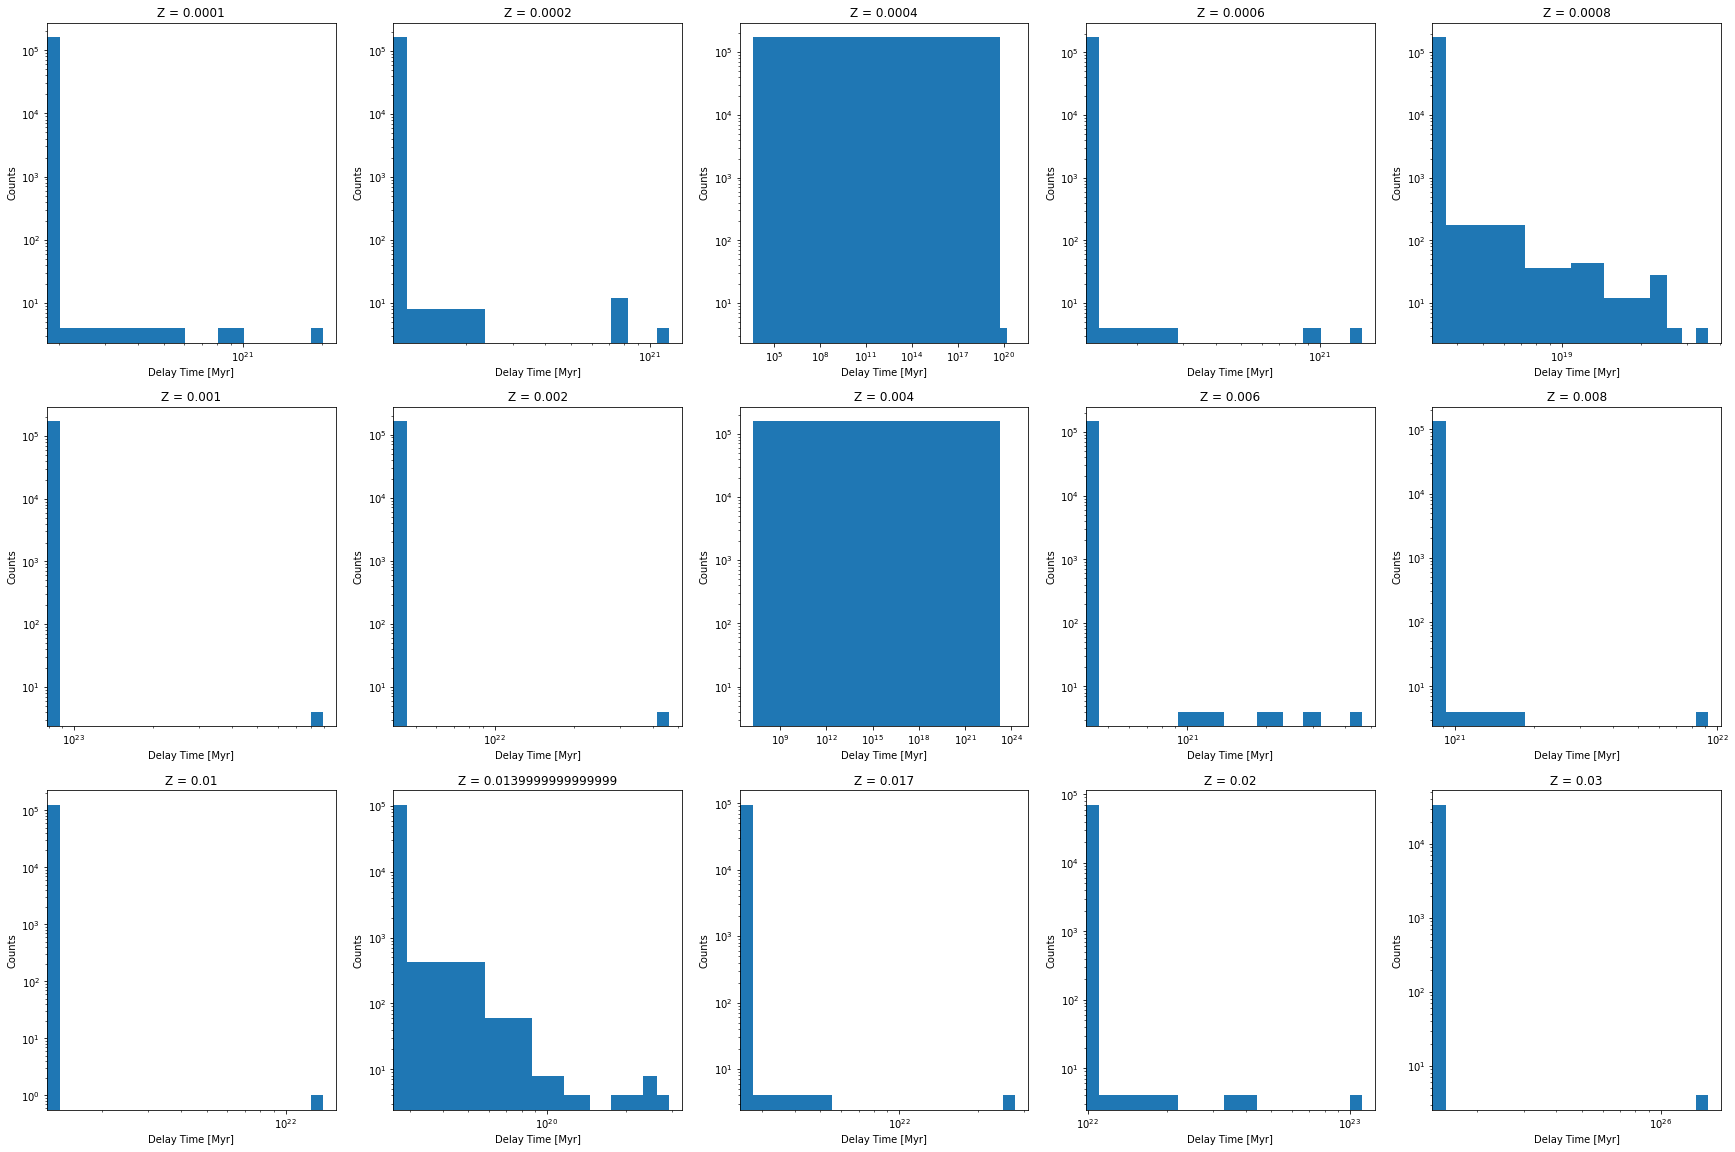

In [7]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].hist(Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

Distribution tabulated delay time for different values of Z.

<function matplotlib.pyplot.show(close=None, block=None)>

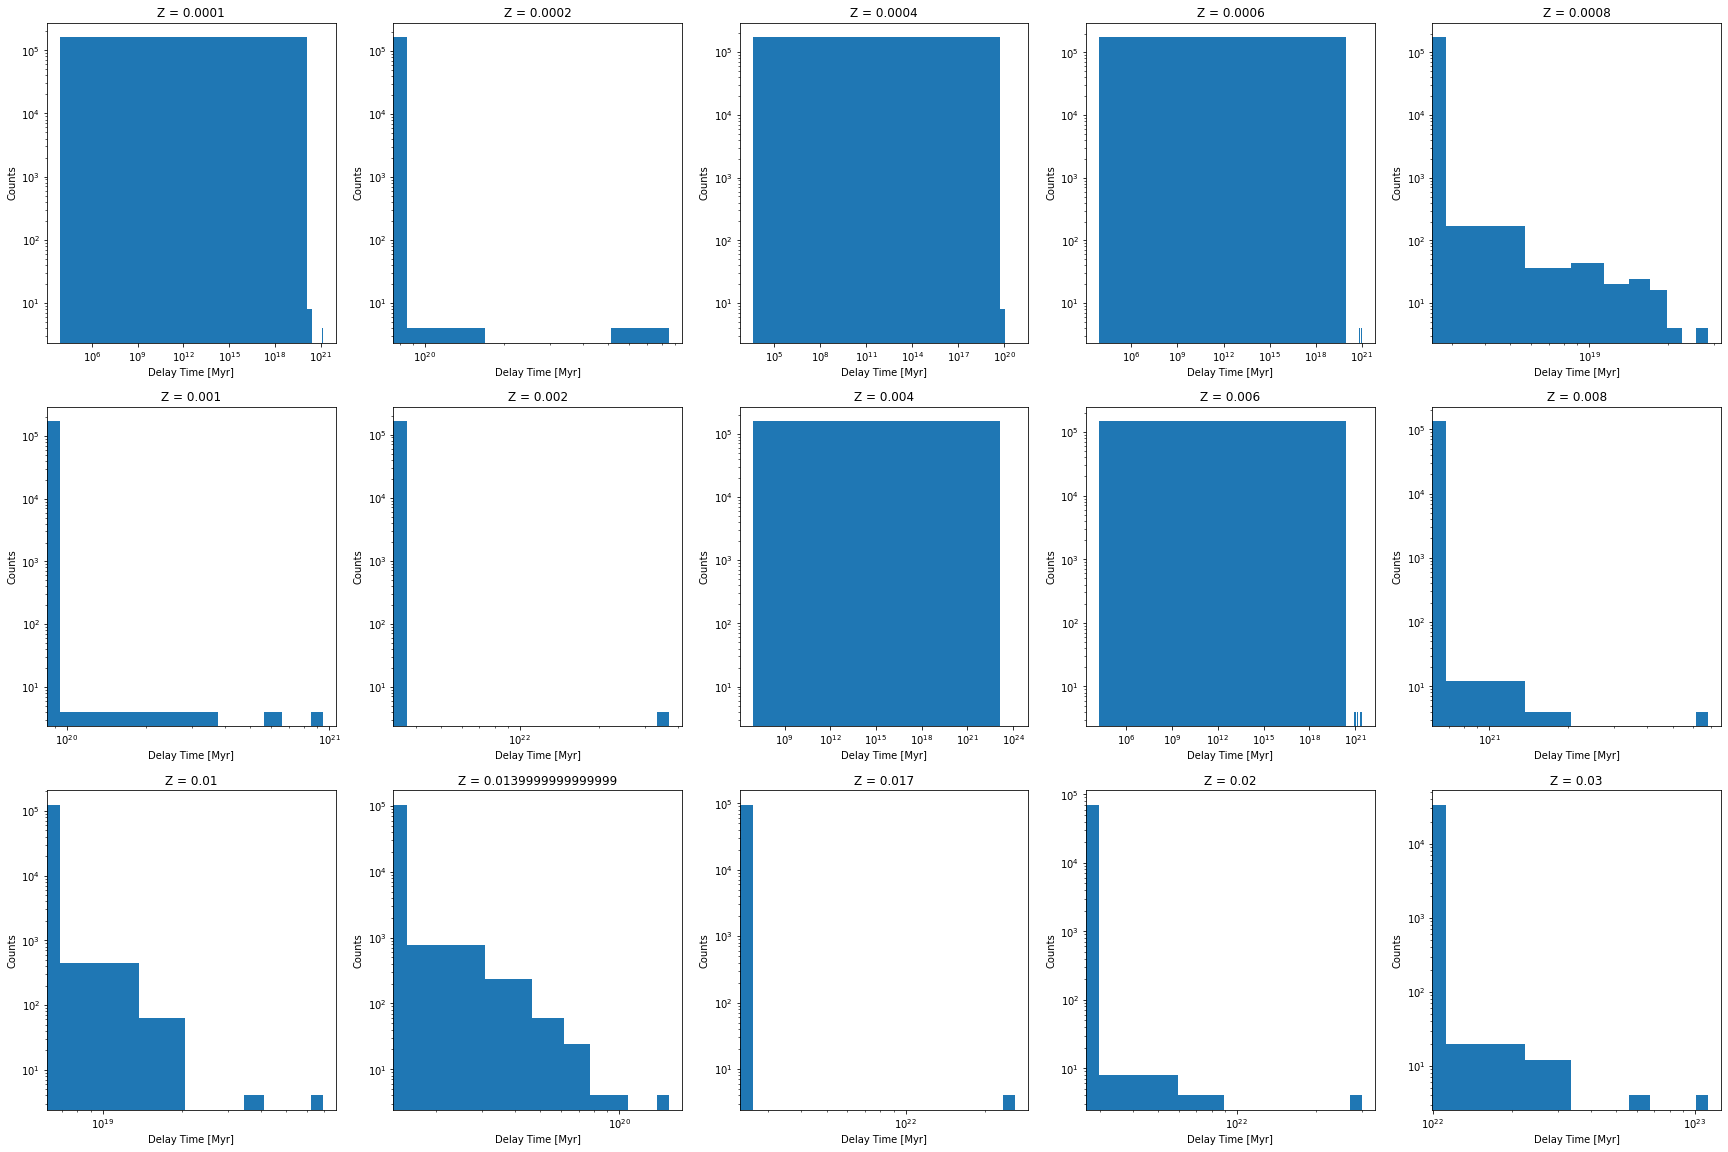

In [8]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].hist(Z_df[key].GWtime+Z_df[key].BWorldtime)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

Distribution computed delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

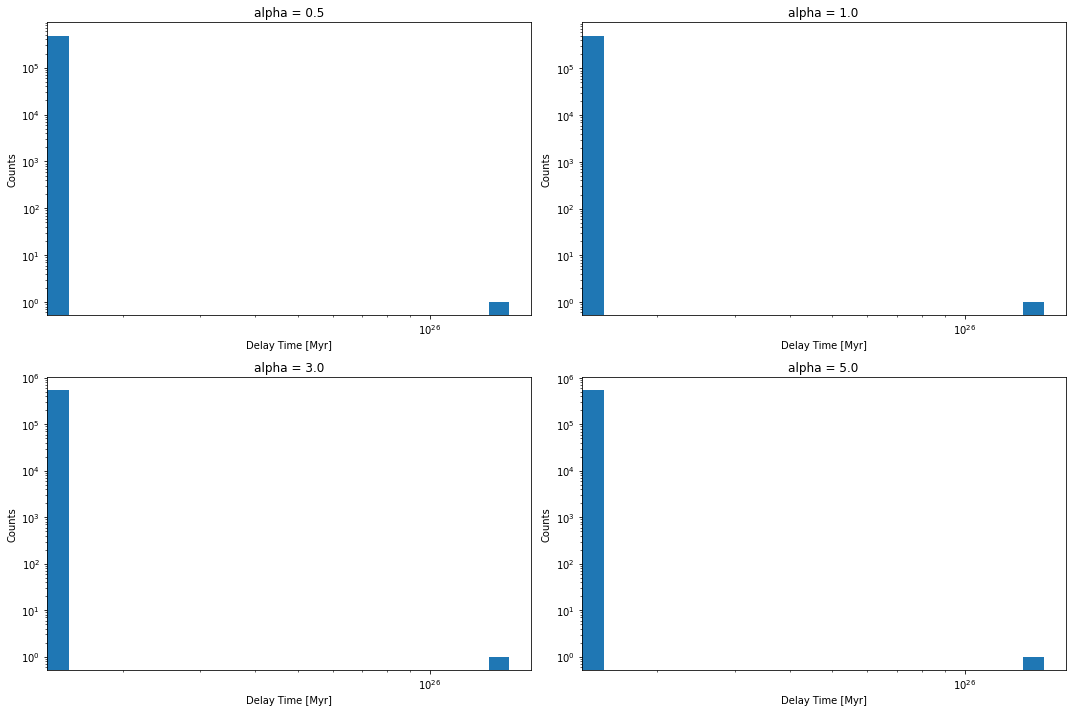

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].hist(alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('alpha = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

Distribution tabulated delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

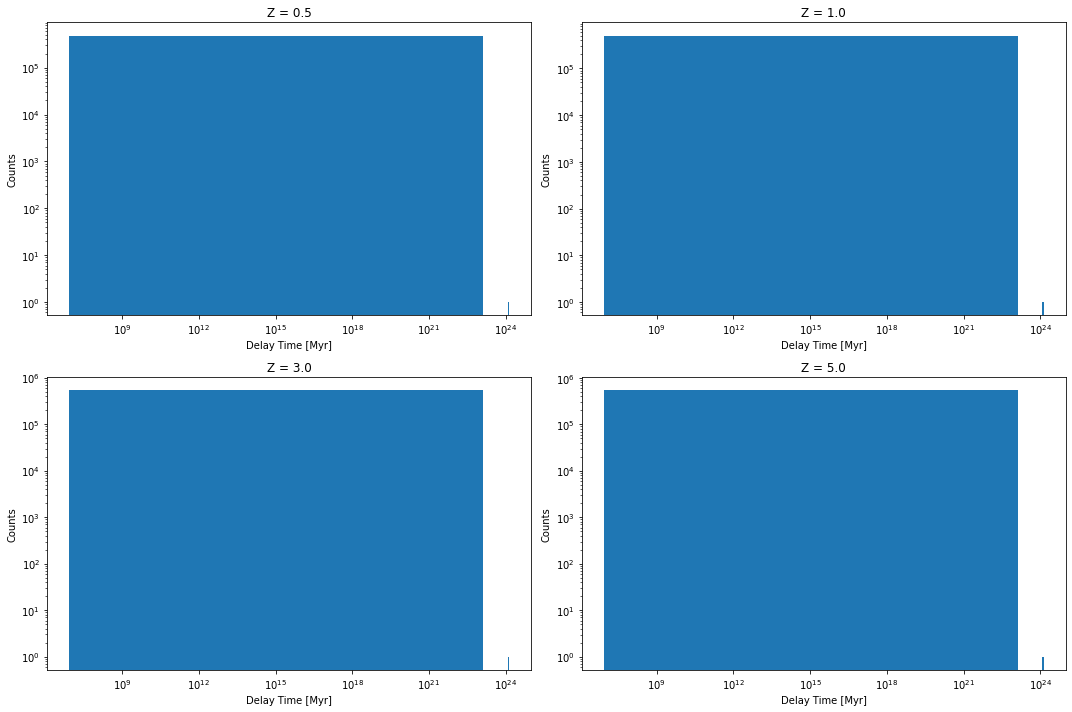

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].hist(alpha_df[key].GWtime+alpha_df[key].BWorldtime)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

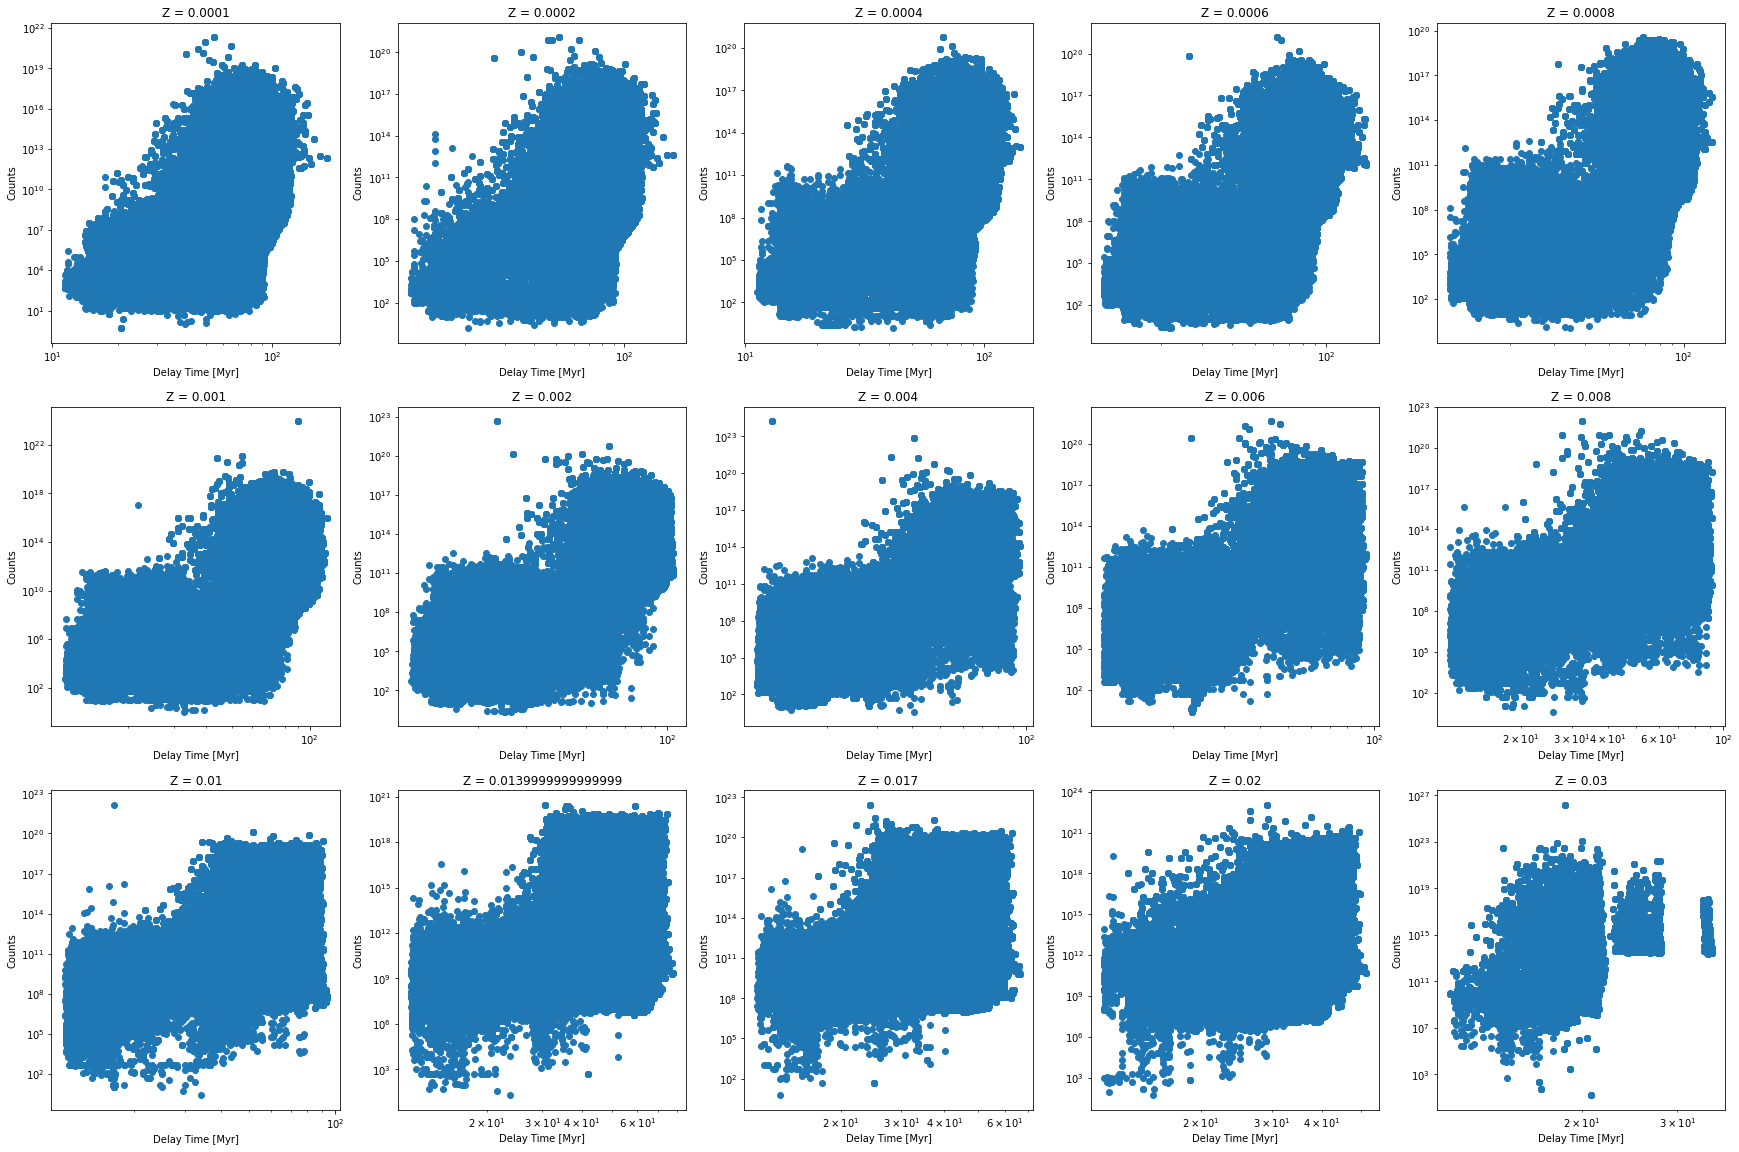

In [11]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_0+Z_df[key].Mass_1, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

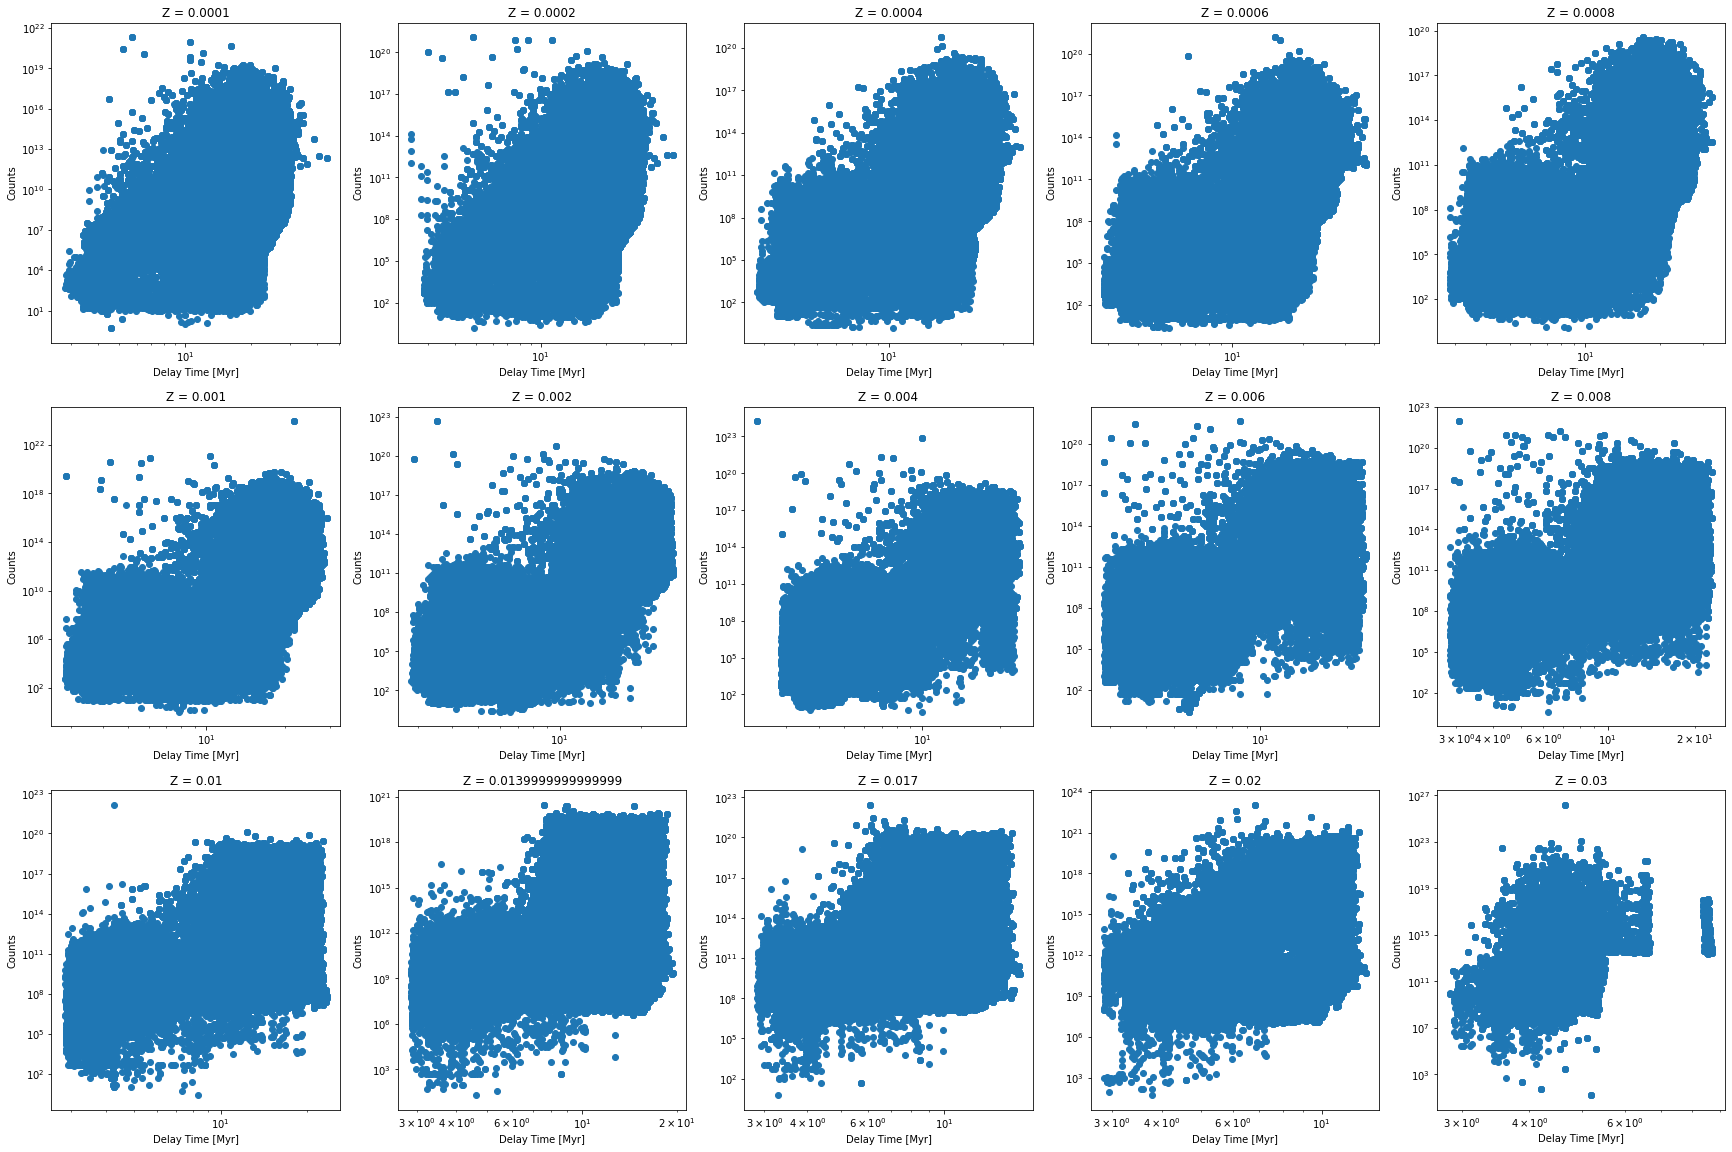

In [12]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_reduced, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show